In [1]:
import sys
import os

import numpy as np
from numpy import random
import pandas as pd
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from IPython import display
%matplotlib inline
from tqdm import tqdm_notebook

PARENT_DIR = os.path.realpath('..')
import importlib
if PARENT_DIR not in sys.path:
    sys.path.append(PARENT_DIR)

try: importlib.reload(sl)
except: import synt_lib as sl

In [2]:
from scipy import sparse

In [3]:
DIRS = sl.get_dirs(parent_dir=PARENT_DIR)
M_PARAMS = sl.get_model_params()

In [4]:
quant = M_PARAMS['QUANTIZATION_CHANNELS']
nbits = int(np.log2(quant))

# Build model

# Get Data

Всего файлов:
* Обучение (cv-valid-train): 391552
* cv-valid-dev: 8152
* cv-valid-test: 7990

# Develop models

## New sparsity

In [39]:
def get_sparse_tensor(sparse_matrix, var, block_size=(16,1), session=None):
    b0, b1 = block_size
    k = tf.cast(var.shape[0]//b0//b1,'int32')
    n0 = sparse_matrix.shape[0]*b0
    n1 = sparse_matrix.shape[1]*b1
    
    tops = tf.math.top_k(tf.reshape(sparse_matrix,(-1,)), k=k)
    ids_flat = tf.cast(tops.indices, 'int64')
    ids = tf.transpose(tf.stack([ids_flat//(sparse_matrix.shape[1]), ids_flat%(sparse_matrix.shape[1])]))
    ids_flat_expand_start = ids[:,0]*n1*b0+ids[:,1]*b1
    ids_flat_expand = tf.reshape(tf.concat([
        tf.concat([ids_flat_expand_start+j for j in range(b1)],0)
            +i*n1 for i in range(b0)],0), (-1,))
    ids_flat_expand = tf.contrib.framework.sort(ids_flat_expand)
    ids_expand = tf.transpose(tf.stack([ids_flat_expand//n1, ids_flat_expand%n1]))
    
    spv = tf.SparseTensor(indices=ids_expand, values=var, dense_shape=(n0,n1))
    return spv

In [148]:
def get_sparse_matrix(k, sparse_tensor, block_size=(16,1)):
    b0,b1 = block_size
    spvd = tf.sparse.to_dense(sparse_tensor)
    shorted = tf.concat([[tf.split(t, spvd.shape[1]//b1, axis=1)] for t in tf.split(spvd, spvd.shape[0]//b0, axis=0)],0)
    shorted = tf.reshape(shorted, (-1,b0,b1))
    means = tf.reduce_mean(tf.abs(tf.reshape(shorted,(-1,b0*b1))),1)
    
    tops = tf.math.top_k(means, k=k)
    ids_flat = tops.indices
    ids = tf.transpose(tf.stack([ids_flat//(n1//b1), ids_flat%(n1//b1)]))
    M1 = tf.sparse.to_dense(tf.SparseTensor(indices=tf.cast(ids,'int64'),
                values=np.ones(shape=ids.shape[0]).astype('int64'),
                dense_shape=(n0//b0, n1//b1)), validate_indices=False)
    
    
    ids = tf.transpose(tf.stack([ids_flat//(n1//b1), ids_flat%(n1//b1)]))
    ids_flat_expand_start = ids[:,0]*n1*b0+ids[:,1]*b1
    ids_flat_expand = tf.reshape(tf.concat([
        tf.concat([ids_flat_expand_start+i*n1 for i in range(b0)],0)
            +j for j in range(b1)],0), (-1,))
    ids_flat_expand = tf.contrib.framework.sort(ids_flat_expand)
    vals = tf.gather(tf.reshape(spvd, (-1,)), ids_flat_expand)
    return M1, vals

In [149]:
b0, b1 = 16, 1

In [248]:
n0, n1 = 64, 5

In [249]:
tf.reset_default_graph()
sess = tf.Session()

Задание переменных и матрицы разреженности

In [250]:
ids = np.concatenate([[(i,j) for j in range(n1//b1)] for i in range(n0//b0)])
M   = tf.sparse.to_dense(tf.SparseTensor(indices=tf.cast(ids,'int64'),
                values=np.ones(shape=ids.shape[0]).astype('int64'),
                dense_shape=(n0//b0, n1//b1)), validate_indices=False)

In [251]:
var = tf.Variable(tf.truncated_normal(shape=(n0*n1,), mean=0, stddev=0.1))

In [252]:
sess.run(tf.global_variables_initializer())

Из матрицы разреженности и переменных получаем матрицу переменных

In [253]:
sess.run(M)

array([[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]])

In [254]:
sess.run(var)

array([ 1.48173645e-02, -9.45874304e-02,  9.18002948e-02,  1.11173252e-02,
       -1.10364258e-01,  2.77783722e-02,  1.83293391e-02,  1.26584783e-01,
       -7.96037074e-03, -1.69906970e-02, -5.11938110e-02,  1.27534745e-02,
        1.52169568e-02, -3.83054465e-02,  6.10993989e-02, -1.84694812e-01,
       -1.20832004e-01,  8.51565525e-02,  7.71720186e-02,  1.11103415e-01,
       -2.81948829e-03,  9.49258610e-05,  2.09338535e-02, -1.24886051e-01,
        1.85317323e-01,  6.02495149e-02,  1.19497024e-01,  6.34684041e-02,
        6.03080280e-02, -9.16151181e-02,  6.16571382e-02, -1.56916901e-01,
       -1.32634370e-02,  1.14329770e-01, -1.10093608e-01,  1.82070583e-01,
       -2.37573846e-03,  1.62164047e-02, -3.96223925e-02, -2.58639734e-02,
        8.43523350e-03, -1.39904439e-01,  1.96343914e-01,  6.83633909e-02,
       -5.70082255e-02, -1.72541309e-02, -6.20838860e-03,  6.96753114e-02,
        6.74176365e-02, -1.29186912e-02,  3.10565513e-02, -4.43022065e-02,
       -1.20038606e-01, -

In [255]:
spv = get_sparse_tensor(M, var, block_size=(b0,b1), session=sess)

In [256]:
tf.sparse.to_dense(spv).eval(session=sess)

array([[ 1.48173645e-02, -9.45874304e-02,  9.18002948e-02,
         1.11173252e-02, -1.10364258e-01],
       [ 2.77783722e-02,  1.83293391e-02,  1.26584783e-01,
        -7.96037074e-03, -1.69906970e-02],
       [-5.11938110e-02,  1.27534745e-02,  1.52169568e-02,
        -3.83054465e-02,  6.10993989e-02],
       [-1.84694812e-01, -1.20832004e-01,  8.51565525e-02,
         7.71720186e-02,  1.11103415e-01],
       [-2.81948829e-03,  9.49258610e-05,  2.09338535e-02,
        -1.24886051e-01,  1.85317323e-01],
       [ 6.02495149e-02,  1.19497024e-01,  6.34684041e-02,
         6.03080280e-02, -9.16151181e-02],
       [ 6.16571382e-02, -1.56916901e-01, -1.32634370e-02,
         1.14329770e-01, -1.10093608e-01],
       [ 1.82070583e-01, -2.37573846e-03,  1.62164047e-02,
        -3.96223925e-02, -2.58639734e-02],
       [ 8.43523350e-03, -1.39904439e-01,  1.96343914e-01,
         6.83633909e-02, -5.70082255e-02],
       [-1.72541309e-02, -6.20838860e-03,  6.96753114e-02,
         6.74176365e-02

In [257]:
var

<tf.Variable 'Variable:0' shape=(320,) dtype=float32_ref>

Прореживаем матрицу и вектор переменных

sparsity_level = 0.5 => k = M.size*0.5

In [258]:
M1, vals = get_sparse_matrix(10, spv, block_size=(b0,b1))

In [259]:
M1.eval(session=sess)

array([[0, 0, 0, 0, 1],
       [1, 1, 1, 0, 0],
       [1, 0, 1, 0, 0],
       [1, 1, 1, 0, 1]])

In [260]:
vals = vals.eval(session=sess)

In [261]:
var1 = tf.Variable(vals)
sess.run(var1.initializer)

In [262]:
spv1 = get_sparse_tensor(M1, var1, block_size=(b0,b1))

Прореживаем ещё раз

sparsity_level = 0.9 => k = M.size*0.1

In [263]:
M2, vals = get_sparse_matrix(2, spv, block_size=(b0,b1))

In [264]:
M2.eval(session=sess)

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0]])

In [265]:
vals = sess.run(vals)
var2 = tf.Variable(vals)
sess.run(var2.initializer)

In [266]:
spv2 = get_sparse_tensor(M2, var2, block_size=(b0,b1))

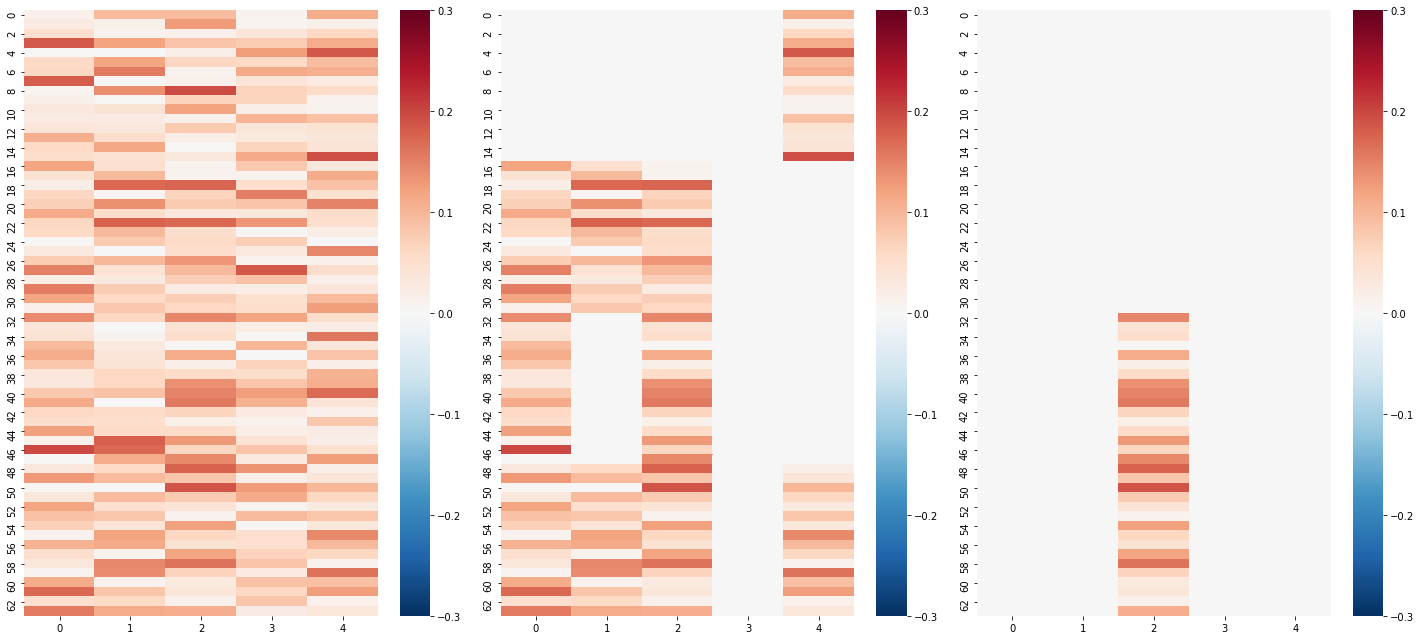

In [267]:
plt.figure(figsize=(20,9))
plt.subplot(131)
sns.heatmap(np.abs(sess.run(tf.sparse.to_dense(spv))), cmap='RdBu_r', center=0, vmin=-0.3, vmax=0.3)

plt.subplot(132)
sns.heatmap(np.abs(sess.run(tf.sparse.to_dense(spv1))), cmap='RdBu_r', center=0, vmin=-0.3, vmax=0.3)

plt.subplot(133)
sns.heatmap(np.abs(sess.run(tf.sparse.to_dense(spv2))), cmap='RdBu_r', center=0, vmin=-0.3, vmax=0.3)

plt.tight_layout()
plt.show()

# New model with new loss

In [5]:
import DWave4
DWave4 = importlib.reload(DWave4)

In [6]:
tf.reset_default_graph()
sess = tf.Session()

In [7]:
gru = DWave4.WaveGRU(3,32, n_batches=3, hidden_size=256)
sess.run(tf.global_variables_initializer())

Instructions for updating:
Use `argmax` instead


In [8]:
txt_emb = np.array([0]*gru.text_embed_size).reshape(1,-1)

In [9]:
aud = gru.generate_audio(txt_emb, sess, seconds=1, show_tqdm=True);

In [13]:
fname = DIRS['RAW_DATA']+'/rus/voxforge_ru/0/00/78d77cdb75be'

In [14]:
os.path.isfile(fname+'.wav')

True

In [118]:
audio_data = sl.load_data([fname+'.wav']).eval(session=sess)
audio_data

array([[[ 0.09375  ,  0.3515625],
        [ 0.       , -1.       ],
        [-0.1015625, -0.359375 ],
        ...,
        [-0.1015625, -0.359375 ],
        [-0.1484375, -0.15625  ],
        [-0.1796875,  0.078125 ]]])

In [119]:
audio_data.shape

(1, 157999, 2)

# New model with new sparse

In [27]:
import DWave5
DWave5 = importlib.reload(DWave5)

In [28]:
tf.reset_default_graph()
sess = tf.Session()

In [29]:
gru = DWave5.WaveGRU(3,32, n_batches=1)
sess.run(tf.global_variables_initializer())

In [30]:
txt_emb = np.array([0]*gru.text_embed_size).reshape(1,-1)

In [31]:
gru.generate(txt_emb, sess, seconds=1, show_tqdm=True);

KeyboardInterrupt: 

In [32]:
gru.sparsify(10, sess)

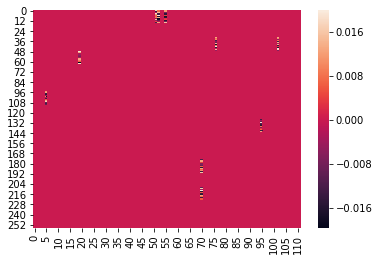

In [33]:
sns.heatmap(tf.sparse.to_dense(gru.O2).eval(session=sess))

In [20]:
%timeit sess.run(tf.sparse.to_dense(gru.O1))

211 ms ± 17.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%timeit sess.run(tf.transpose(tf.sparse.to_dense(gru.O1)))

208 ms ± 5.12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
tf.sparse_matmul

<function tensorflow.python.ops.gen_math_ops.sparse_mat_mul(a, b, transpose_a=False, transpose_b=False, a_is_sparse=False, b_is_sparse=False, name=None)>

In [632]:
fname = DIRS['RAW_DATA']+'/rus/voxforge_ru/0/00/78d77cdb75be'

In [34]:
gru.generate(txt_emb, sess, seconds=1, show_tqdm=True);

KeyboardInterrupt: 

In [650]:
st = gru.O1
dt = tf.sparse.to_dense(gru.O1)
b = tf.sparse.to_dense(gru.O3)

In [719]:
ddt = tf.truncated_normal(shape=(112,112))

In [722]:
%timeit tf.matmul(ddt,b).eval(session=sess)

4.56 s ± 60.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [715]:
%timeit tf.matmul(dt,b).eval(session=sess)

4.77 s ± 24.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [714]:
%timeit tf.sparse_matmul(dt, b, a_is_sparse=True).eval(session=sess)

5.52 s ± 524 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [713]:
%timeit tf.sparse.matmul(st, b).eval(session=sess)

5.59 s ± 1.32 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [678]:
%timeit tf.sparse.to_dense(st).eval(session=sess)

4.45 s ± 83.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [679]:
%timeit tf.matmul(dt, b).eval(session=sess)

4.68 s ± 86.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [680]:
from scipy import sparse

In [685]:
sm = sparse.rand(100,100)

In [687]:
dm = sm.todense()

In [692]:
bm = np.random.uniform(1000, size=(100,50))

In [694]:
bm.shape

(100, 50)

In [696]:
sm.dot(bm)

array([[ 21.90327031,  22.79747875,  28.2839467 , ...,  51.50201028,
         18.1698047 ,  48.13643452],
       [ 72.07792034,  22.79876165,  66.37136451, ...,  18.37547631,
         70.80597013,  62.5579461 ],
       [275.26543723, 448.06773968, 204.59681437, ..., 263.66549137,
        339.01144816, 395.91691887],
       ...,
       [194.53619815, 164.21463234, 232.61331281, ..., 334.06080179,
        322.57524272,  77.14858423],
       [239.15630064, 395.19244483, 266.55946336, ..., 612.75429635,
        419.27576721,  84.36460159],
       [314.9828428 , 181.20286811,   7.47148344, ..., 284.21892323,
        445.65878323, 465.67777703]])

In [703]:
%timeit sm.dot(bm)

127 µs ± 1.96 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [704]:
%timeit dm.dot(bm)

22.1 µs ± 487 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [666]:
tf.linalg.matmul(st,b, a_is_sparse=True)

TypeError: Failed to convert object of type <class 'tensorflow.python.framework.sparse_tensor.SparseTensor'> to Tensor. Contents: SparseTensor(indices=Tensor("transpose_63:0", shape=(160, 2), dtype=int64), values=Tensor("O1V_1:0", shape=(160,), dtype=float32_ref), dense_shape=Tensor("SparseTensor_24/dense_shape:0", shape=(2,), dtype=int64)). Consider casting elements to a supported type.

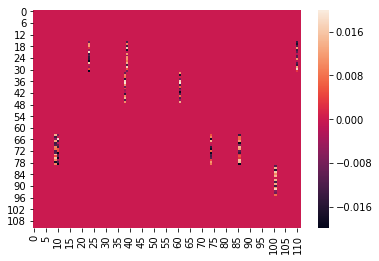

In [662]:
sns.heatmap(dt.eval(session=sess))

In [643]:
st

In [644]:
dt

<tf.Tensor 'SparseToDense_28:0' shape=(112, 112) dtype=float32>